In [1]:
import numpy as np

def generate_price_paths(S0, r, sigma, T, M, I):
    dt = T / M
    paths = np.zeros((M + 1, I))
    paths[0] = S0
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    return paths


In [2]:
from keras.models import Sequential
from keras.layers import Dense

def create_neural_network(input_dim):
    model = Sequential()
    model.add(Dense(50, input_dim=input_dim, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [3]:
def longstaff_schwartz(paths, K, r, T, M):
    # Initialize the cash flow matrix
    cash_flows = np.maximum(paths[-1] - K, 0)

    # Iterate backwards in time
    for t in range(M-1, 0, -1):
        in_the_money = paths[t] > K
        X = paths[t, in_the_money]
        Y = np.exp(-r * T/M) * cash_flows[in_the_money]
        
        model = create_neural_network(input_dim=1)
        model.fit(X, Y, epochs=5, verbose=0)
        
        continuation_values = model.predict(X)
        exercise_values = np.maximum(K - paths[t, in_the_money], 0)
        exercise = exercise_values > continuation_values.squeeze()
        
        cash_flows[in_the_money] = np.where(exercise, exercise_values, np.exp(-r * T/M) * cash_flows[in_the_money])

    return [np.mean(cash_flows) * np.exp(-r * T), cash_flows]


In [18]:
S0 = 100         # Initial stock price
K = 100          # Strike price
T = 1            # Time to maturity
r = 0.05         # Risk-free rate
sigma = 0.2      # Volatility
M = 3            # Number of time steps
I = 10000        # Number of simulation paths

paths = generate_price_paths(S0, r, sigma, T, M, I)
option_price,cash_flows = longstaff_schwartz(paths, K, r, T, M)
print(f"Estimated Option Price: {option_price}")

170/170 [==============================] - 0s 1ms/step
Estimated Option Price: 10.304806532134267


In [19]:
def calculate_pnl(paths, cash_flows, option_price, K):
    payoffs = np.maximum(paths[-1] - K, 0)
    pnl = cash_flows - option_price
    return pnl

In [20]:
import matplotlib.pyplot as plt

def plot_pnl_distribution(pnl):
    plt.figure(figsize=(10, 6))
    plt.hist(pnl, bins=50, alpha=0.7)
    plt.title("Profit and Loss Distribution")
    plt.xlabel("Profit/Loss")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

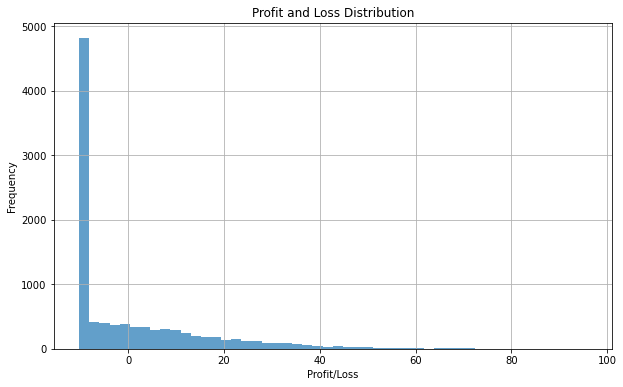

In [21]:
pnl = calculate_pnl(paths, cash_flows, option_price, K)

# Plot P&L Distribution
plot_pnl_distribution(pnl)

In [22]:
def calculate_deltas(paths, cash_flows, K, r, T, M):
    dt = T / M
    deltas = np.zeros_like(paths)

    for t in range(1, M):
        up_paths = paths.copy()
        down_paths = paths.copy()
        up_paths[t:] *= 1.01
        down_paths[t:] *= 0.99

        up_value = longstaff_schwartz(up_paths, K, r, T, M)[0]
        down_value = longstaff_schwartz(down_paths, K, r, T, M)[0]
        
        deltas[t] = (up_value - down_value) / (0.02 * paths[t])

    return deltas

In [23]:
def calculate_pnl_with_hedging(paths, cash_flows, deltas, S0, r, T, M):
    dt = T / M
    pnl = np.zeros_like(cash_flows)

    for t in range(1, M):
        hedge_amount = deltas[t] * paths[t]
        pnl += hedge_amount * (paths[t + 1] - paths[t]) - r * hedge_amount * dt

    pnl += cash_flows - np.exp(-r * T) * hedge_amount
    return pnl

170/170 [==============================] - 0s 935us/step


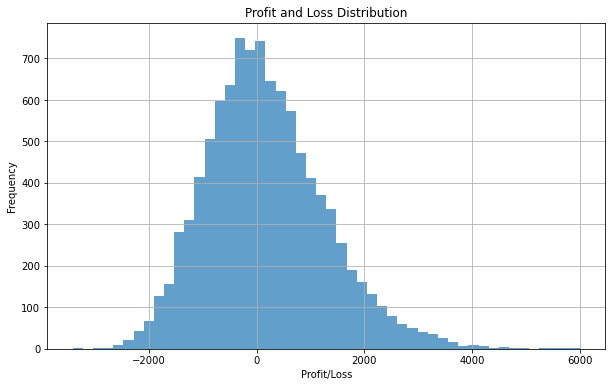

In [24]:
deltas = calculate_deltas(paths, cash_flows, K, r, T, M)
pnl_hedged = calculate_pnl_with_hedging(paths, cash_flows, deltas, S0, r, T, M)

# Plot P&L Distribution for Hedged Portfolio
plot_pnl_distribution(pnl_hedged)